# Covid-19 $R_t$ in real-time (Ticino region)

In this exercise adapted from [Kevin Systrom repository](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb), we'll measure $R_t$, the number of people who become infected per infectious person at time t. The basic reproduction number is $R_0$ at t=0, the average number of secondary infections produced by a typical case of an infection in a population when everyone is susceptible.

The basic reproductive number is affected by several factors:

* The rate of contacts in the host population
* The probability of infection being transmitted during contact
* The duration of infectiousness

**Note**: the code below is taken from the author repository mentioned above. The goal is to understand the procedure and apply it for the data relevant for our Ticino region.

# 1. Poisson distribution function approach

### 1.1 Choosing a likelihood function $P\left(k_t|R_t\right)$

How is it likely to have k new cases give a value or Rt?

In [1]:
# 'arrivals' model -> poisson distribution
# λ = average new cases per day
# probability of seeing k new cases is distributed with a poisson distribution

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

In [11]:
# import packages
import numpy as np
import pandas as pd
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# create vector for k (0 to 69 with step 1)
k = range(70)

# create list of different lambdas
lambdas = [10, 20, 30, 40]

# initialize empty matrix
y = np.zeros((len(k), len(lambdas)))

In [13]:
# probability mass function (PMF) for every lambda (poisson is discrete)
for i in range(len(lambdas)):
    y[:,i] = poisson.pmf(k, lambdas[i])
    
print(y.shape)

(70, 4)


In [19]:
# create pmf dataframe
pmf_df = pd.DataFrame(y, columns=['k10', 'k20', 'k30', 'k40'])
pmf_df.head()

,k10,k20,k30,k40
0,0.000045,2.061154e-09,9.357623e-14,4.248354e-18
1,0.000454,4.122307e-08,2.807287e-12,1.699342e-16
2,0.002270,4.122307e-07,4.210930e-11,3.398683e-15
3,0.007567,2.748205e-06,4.210930e-10,4.531578e-14
4,0.018917,1.374102e-05,3.158198e-09,4.531578e-13


In [21]:
# set sns theme
sns.set_theme()

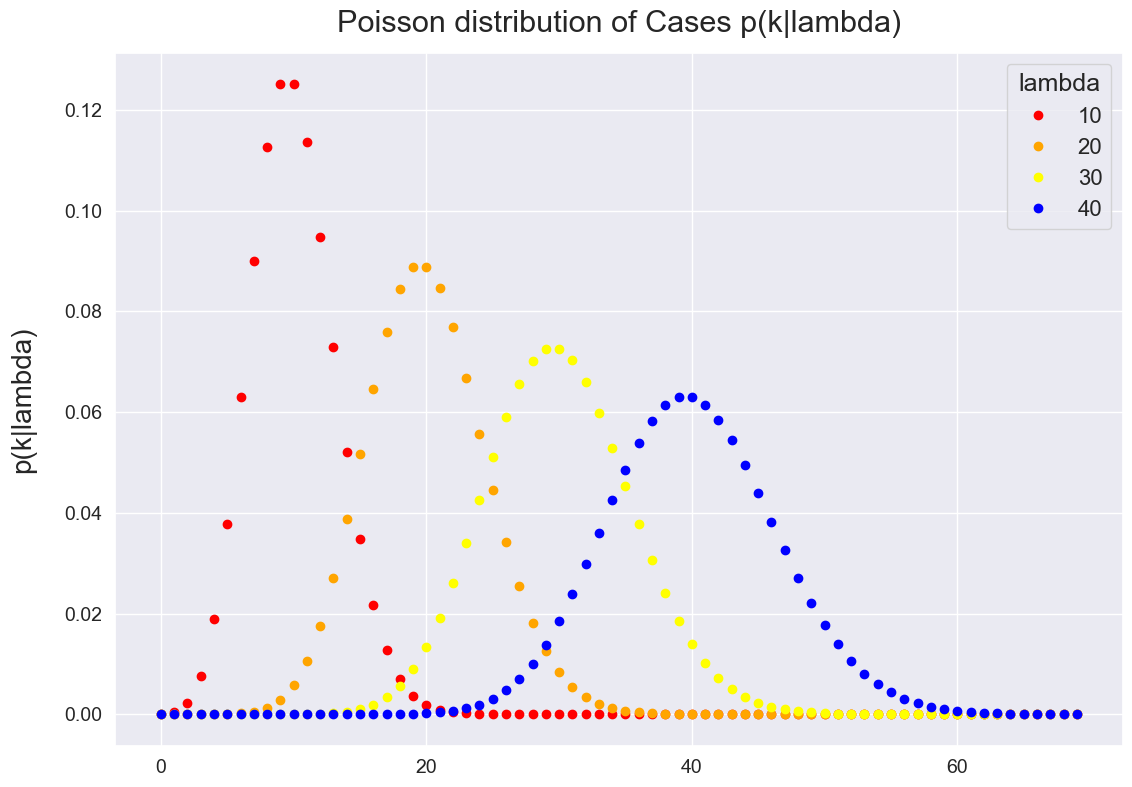

In [26]:
# plot

# plot for each lambda
ax = pmf_df.plot(marker = 'o',
                 linestyle = 'None',
                 fontsize = 14,
                 figsize = (13,9),
                 color = ['red', 'orange', 'yellow', 'blue'],
                 xticks = [0, 20, 40, 60]
                 )

# set y label
ax.set_ylabel("p(k|lambda)", fontdict = {'fontsize': 20}, labelpad = 20)

# set legend and legend title
leg = ax.legend(fontsize = 16, title= 'lambda', labels = [lab[1:] for lab in pmf_df.columns])
leg.set_title('lambda', prop = {'size':18})

# set plot title
ax.set_title("Poisson distribution of Cases p(k|lambda)", pad = 15, fontdict = {'size':22});

### 1.2 Connecting lambda and Rt

We have $P\left(\lambda_t|k_t\right)$ which is parameterized by $\lambda$
but we were looking for $P\left(k_t|R_t\right)$ which is parameterized by $R_t$.
We need to know the relationship between $\lambda$ and and $R_t$.

Since we know every new case count on the previous day, we can now reformulate
the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

### 1.3 Evaluating the likelihood function

What is the likelihood of different value of Rt on each of the days that have k new case counts?

In [27]:
# given a set of new case counts k list
k = np.array([20, 40, 55, 90])

In [28]:
# create array for all possible values of Rt
R_T_MAX = 12
r_t_range = np.linspace(start = 0, stop = R_T_MAX, num = R_T_MAX*100+1)

In [30]:
# set gamma (1/serial interval)
GAMMA = 1/7

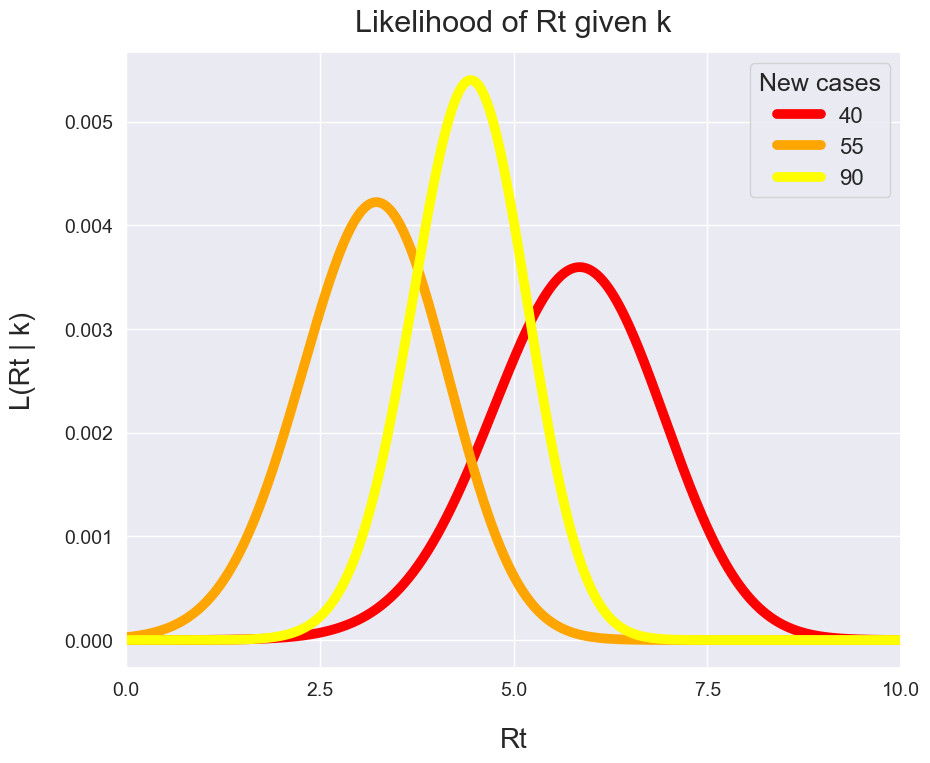

In [39]:
# map rt into lambda
# !!! N-1 lambdas because on the first day of an outbreak you don't know what to expect
lam = np.dot(k[:-1].reshape(-1,1), np.exp(GAMMA * (r_t_range - 1).reshape(1,-1)), )

# evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = np.zeros((lam.shape[1], len(k)-1)) # initialize an empty matrix  

for i in range(len(k)-1):
    likelihood_r_t[:,i] = poisson.pmf(k[1:][i], lam[i])

# sum of the elements of vector (along rows)
lh = np.sum(likelihood_r_t, axis = 0)

# normalization 
likelihood_r_t = (lambda x: x/lh)(likelihood_r_t)

# plot dataframe
likelihood_df = pd.DataFrame(likelihood_r_t, r_t_range).reset_index()
likelihood_df.columns = ['Rt', 'k40', 'k55', 'k90']

# plot by different k
ax = likelihood_df.set_index('Rt').plot(
    fontsize = 14,
    figsize = (10,8),
    color = ['red', 'orange', 'yellow'],
    lw = 7,
    xlim = (0, 10),
    xticks = [0, 2.5, 5, 7.5, 10]
    )

# set labels, legend, titles
ax.set_ylabel("L(Rt | k)", fontdict = {'fontsize': 20}, labelpad = 20)
ax.set_xlabel("Rt", fontdict = {'fontsize': 20}, labelpad = 20)
leg = ax.legend(fontsize = 16, labels = [40, 55, 90])
leg.set_title('New cases', prop = {'size':18})
ax.set_title("Likelihood of Rt given k", pad = 15, fontdict = {'size':22})
ax;

- for each day we have an independent guess for Rt
- we know that Rt today depends on Rt-1 and so on
- bayesian statistics let us incorporate prior knowledge into parameter estimation

## 2. Bettencourt & Ribeiro's approach

Having seen k new cases, we believe that the distirbution Rt is equal to, **for a single day**:

- the likelihood of seeing k new cases given Rt
- multiplied by
- the prior belief of the value of P(Rt) without the data
- divided by
- the probability of seeing this many cases in general

For multiple days, we'll assume that the distribution of Rt is Gaussian centered around Rt-1.

### 2.1 Bayesian update (combine the information in the previous days with current day)